In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyshtools
from pyshtools import spectralanalysis as spec
import pandas as pd
import sys
import os
import cartopy.crs as ccrs
sys.path.insert(0,'/home/claire/Works/exo-top/')
from john_scripts.venus_topo_stats import RMS_from_l_powerspectrum, read_coeffs, plot_Venus 
from john_scripts.hoggard import read_hoggard
from exotop.asharms import powerspectrum_RMS
from exotop.postaspect.aspect_scalings import fit_log

In [13]:
def powerspectraldensity(cilm, lmax):
    pspectrum = np.zeros(lmax)
    for l in np.arange(0, lmax):
        sum_m_i1 = np.sum(cilm[0, l+1]**2 / (2*l + 1))
        sum_m_i2 = np.sum(cilm[1, l+1]**2 / (2*l + 1))
    
        pspectrum[l] = sum_m_i1 + sum_m_i2
    return pspectrum

def load_spectrum(fname='', path='/home/claire/Works/exo-top/benchmarks/'):
    df = pd.read_csv(path+fname, header=None, names=['degree', 'value'], index_col=False, engine='python') 
    ls = np.array(df['degree'])
    S = np.array(df['value'])
    return ls, S

In [21]:
def shfit_slope(clm=None, a0=1, lmax=30, lmin_fit=2, S=None, l=None, meansealevel=False, title='', alpha=1.9, C1=0.1, km=False,
               labelsize=16, unit='per_lm', fig=None, ax=None, label='observed', lw=1, fmt='g', fmt_fit='r--'):
    if ax is None:
        fig = plt.figure()
        ax = plt.gca()
    
    if S is None:
        try:
            coeffs = clm.coeffs
        except AttributeError:
            coeffs = clm.SHCoeffs
        if km:
            coeffs = coeffs*1e-3
        if lmax is None:
            lmax = np.shape(coeffs[0,1])[0] - 1
        S = clm.spectrum(unit=unit, lmax=lmax)
        if meansealevel:
            S = S * a0
            

    if l is None:        
        l = np.arange(0, lmax+1)
    k = l / (2*np.pi*a0) * 1e3 # in km

    """ fit """
    
    # exclude short-wavelength (lambda < 15 km)
    i_short = np.argmax(1/k >= 15)
    if i_short == 0:
        i_short = -1

    slope, intercept = fit_log(k[lmin_fit:i_short], S[lmin_fit:i_short])
    beta = -slope
    if (C1 is None) and (alpha is None):
        K2 = 0
    else:
        K2 = C1/(alpha-1) * (2**alpha - 2)
        print('K(q=2) =', K2)
    H = (beta - 1 + K2)/2
    d = 2 # Euclidean dimension
    D = d - H
    print('H monofractal =', (beta - 1)/2)
    print('beta =', beta)
    print('H =', H)
    print('D =', D)

    ax.plot(k[lmin_fit:i_short], intercept*k[lmin_fit:i_short]**-beta, fmt_fit, lw=lw, label='fit, b = {:.2f}, H = {:.2f}'.format(beta, H))
    
#     # compare to beta = 1.85
#     slope, intercept = fit_log(k[lmin_fit:i_short], S[lmin_fit:i_short], intercept=True, slope=-1.85)
#     beta = -slope
#     H = (beta - 1)/2
#     plt.plot(k[lmin_fit:i_short], intercept*k[lmin_fit:i_short]**-beta, c='xkcd:purple', ls='--', label='fit to data, forcing slope=-2, H = {:.2f}'.format(H))
    
    
    ax.plot(k, S, fmt, label=label, lw=lw)
    ax.set_xscale('log')
    ax.set_yscale('log')

    
    ax.set_xlabel('wavenumber (km$^{-1}$)', fontsize=labelsize)
    if km:
        ax.set_ylabel('power spectral density (km$^{3}$)', fontsize=labelsize)
    else:
        ax.set_ylabel('power spectral density (m$^{3}$)', fontsize=labelsize)
    ax.set_title(title, fontsize=labelsize)
    ax.legend()
    return fig, ax

K(q=2) = 0.1924591073496922
H monofractal = 0.8362066647040782
beta = 2.6724133294081565
H = 0.9324362183789243
D = 1.0675637816210757
RMS_topo 960.0306266904499 m
RMS_topo Wei 691.7743078490267 m

model
K(q=2) = 0.1924591073496922
H monofractal = 1.044117445049624
beta = 3.088234890099248
H = 1.14034699872447
D = 0.8596530012755299


/home/claire/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide


(0.01, 10000000.0)

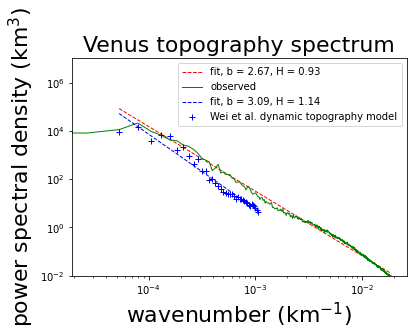

In [23]:
""" can you reproduce H=1/2 for Venus? (observed, dyn top modelled) """
labelsize=22

# clm, cilm = read_coeffs(path='/home/claire/Works/exo-top/benchmarks/sph_Venus/')
clm = pyshtools.datasets.Venus.VenusTopo719()
a0 = pyshtools.constants.Venus.r.value

fig, ax = shfit_slope(clm, a0=a0, lmax=None, lmin_fit=2, meansealevel=False, title='Venus topography spectrum',
           labelsize=labelsize, km=True, unit='per_lm', fmt='g', fmt_fit='r--', lw=1)

RMS = RMS_from_l_powerspectrum(clm)
    

# for model dynamic topography
lw, Sw = load_spectrum(fname='model_power_m2_b.csv', 
                       path='/home/claire/Works/exo-top/benchmarks/wei_Venus/')
RMS_topo = np.sqrt(np.sum(Sw))
print("RMS_topo Wei", RMS_topo, "m")
Sw = Sw/(2*lw + 1)
print('\nmodel')
fig, ax = shfit_slope(S=Sw, l=lw, a0=a0, lmax=40, lmin_fit=0, meansealevel=False, title='Venus topography spectrum',
                      labelsize=labelsize, km=True, unit='per_lm', fmt='b+', fmt_fit='b--',
                     label='Wei et al. dynamic topography model', fig=fig, ax=ax)

# """ fit model """

# slope, intercept = fit_log(k[lmin_fit:], Sw[lmin_fit:])
# beta = -slope
# print('model:\nbeta =', beta)
# H = (beta - 1)/2
# D = (beta - 5)/-2
# print('H =', H)
# print('D =', D)
# plt.plot(k[lmin_fit:], intercept*k[lmin_fit:]**-beta, 'b--', label='fit to model, H = {:.2f}'.format(H))

ax.set_ylim(1e-2, 1e7)

K(q=2) = 0.1924591073496922
H monofractal = 0.285128051065197
beta = 1.570256102130394
H = 0.3813576047400431
D = 1.618642395259957


/home/claire/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide


Text(0, 0.5, 'power spectral density (km$^{-3}$)')

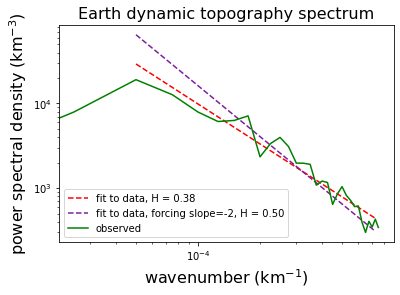

In [44]:
""" Earth d.t. from Hoggard """
lmax = 30
a0 = pyshtools.constants.Earth.wgs84.r3.value
cilm, clm = read_hoggard(filename='NGS-2015-07-01303-s13.csv', file_path='/home/claire/Works/hoggard/', 
                         to_km=True, lmax=lmax)

shfit_slope(clm, a0=a0, lmax=lmax, meansealevel=True, title='Earth dynamic topography spectrum')
plt.ylabel(r'power spectral density (km$^{-3}$)')

/home/claire/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide


K(q=2) = 0.1924591073496922
H monofractal = 0.8861363958804083
beta = 2.7722727917608165
H = 0.9823659495552544
D = 1.0176340504447456


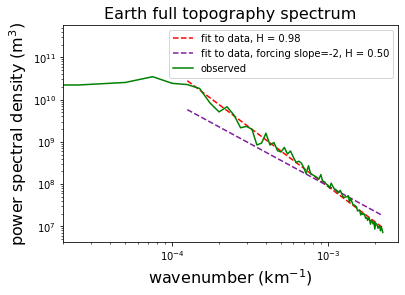

In [45]:
""" Earth full topography """
a0 = pyshtools.constants.Earth.wgs84.r3.value
clm_Earth2014 = pyshtools.datasets.Earth.Earth2014.surface(lmax=90)
lmin_fit = 5

shfit_slope(clm_Earth2014, a0=a0, lmax=None, lmin_fit=lmin_fit, meansealevel=True, title='Earth full topography spectrum')

/home/claire/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide


K(q=2) = 0.1924591073496922
H monofractal = 1.0913181760306407
beta = 3.1826363520612815
H = 1.1875477297054868
D = 0.8124522702945132
RMS_topo 6688.627942023225 m


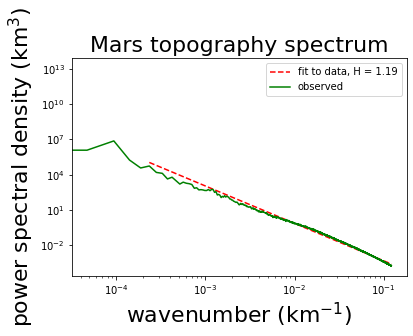

In [6]:
""" MARS """
labelsize=22

# clm, cilm = read_coeffs(path='/home/claire/Works/exo-top/benchmarks/sph_Venus/')
clm = pyshtools.datasets.Mars.MarsTopo2600()
a0 = pyshtools.constants.Mars.r.value
lmin_fit=5
fig, ax = shfit_slope(clm, a0=a0, lmax=None, lmin_fit=lmin_fit, meansealevel=False, title='Mars topography spectrum',
           labelsize=labelsize, km=True, unit='per_lm')

RMS = RMS_from_l_powerspectrum(clm)